In [9]:
import pandas as pd
import numpy as np
import os
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier, LGBMRegressor
import random
from scipy.stats import randint
import xgboost as xgb
import seaborn as sns


from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Causal Inference with CausalML

In [12]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor, BaseSClassifier, BaseXClassifier, BaseRClassifier, BaseTClassifier
from causalml.inference.meta import BaseXLearner, BaseRLearner, BaseSLearner, BaseTLearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

In [3]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/data/hr_attrition.csv'
df = pd.read_csv(url)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Custom Functions

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### returns split data that has been standardized
def standardize(data):
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # standardizing numerical variables
    sc = StandardScaler()
    X = data[df_num]
    y = data['Attrition']
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 6)
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.fit(X_test)
    X_val_std = sc.fit(X_val)
    
    
    return X_train_std, X_test_std, X_val_std, y_train, y_test, y_val


### returns DataFrame with non-standardized numerical variables and encoded categorical variables
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [5]:
df_enc = transform_encoding(df)
df_enc.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1.0,1102,1,1.0,1,1.0,94,2.0,...,6,4,0,5,0,1,0,0,1,1
1,49,0,2.0,279,8,0.0,1,2.0,61,1.0,...,10,7,1,7,1,0,1,1,0,0
2,37,1,1.0,1373,2,1.0,4,3.0,92,1.0,...,0,0,0,0,1,0,1,0,1,1
3,33,0,2.0,1392,3,3.0,1,3.0,56,2.0,...,8,7,3,0,1,0,0,1,0,1
4,27,0,1.0,591,2,0.0,3,0.0,40,2.0,...,2,2,2,2,1,0,1,1,0,0


In [6]:
# function which returns the most important features using RFE with a desired number of features and desired estimator
def important_features(estim, num):
    X_enc = df_enc.drop('Attrition', axis = 'columns')
    y_enc = df_enc['Attrition']

    rfe = RFE(estimator = estim, step = 1, n_features_to_select = num)
    rfe.fit(X_enc, y_enc)

    feats = pd.DataFrame(rfe.ranking_)
    feats['Feature'] = X_enc.columns

    feats_to_use = list(feats[feats[0] < 2]['Feature'])
    
    return feats_to_use

Getting the features used in our final model to select some for causal inference analysis.

In [7]:
feats = important_features(LGBMClassifier(n_estimators = 40, random_state = 6), 22)
feats

['Age',
 'BusinessTravel',
 'DailyRate',
 'DistanceFromHome',
 'EducationField',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobRole',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'OverTime_Yes']

## Iteration 1<br>
Investigating potential causality between `OverTime_Yes` and `Attrition`

In [17]:
import dowhy
from dowhy import CausalModel

In [19]:
X = df_enc[feats]

model = CausalModel(
    data = df_enc,
    treatment = 'OverTime_Yes',
    outcome = 'Attrition',
    common_causes = list(X.drop('OverTime_Yes', axis = 'columns').columns)
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['OverTime_Yes'] on outcome ['Attrition']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


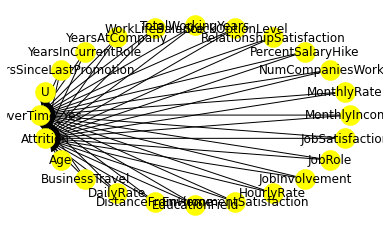

In [20]:
model.view_model()

In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                test_significance = True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~OverTime_Yes+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Attrition~OverTime_Yes+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
Target units: ate

## Estimate
Mean value: 0.21588184537128674
p-value: [3.76385992e-27]

Causal Estimate is 0.21588184537128674


##### It seems like there is a significant relationship between the two. Employees working overtime tend to be about 21% more likely to leave than those who are not working overtime.

Testing for relationship between `YearsSinceLastPromotion` and `Attrition`

In [23]:
X = df_enc[feats]

model = CausalModel(
    data = df_enc,
    treatment = 'YearsSinceLastPromotion',
    outcome = 'Attrition',
    common_causes = list(X.drop('YearsSinceLastPromotion', axis = 'columns').columns)
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['YearsSinceLastPromotion'] on outcome ['Attrition']


In [24]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                test_significance = True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~YearsSinceLastPromotion+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Attrition~YearsSinceLastPromotion+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
Target units: ate

## Estimate
Mean value: 0.014113916779288277
p-value: [0.00011849]

Causal Estimate is 0.014113916779288277


For every year since an employee's last promotion, there is about a 1% increase in the probability that they leave. This is unlikely to be a linear relationship, though, as employees that have not been promoted in a very long time are probably most likely to leave.

Testing for relationship between `StockOptionLevel` and `Attrition`

In [25]:
X = df_enc[feats]

model = CausalModel(
    data = df_enc,
    treatment = 'StockOptionLevel',
    outcome = 'Attrition',
    common_causes = list(X.drop('StockOptionLevel', axis = 'columns').columns)
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['StockOptionLevel'] on outcome ['Attrition']


In [26]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                test_significance = True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~StockOptionLevel+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Attrition~StockOptionLevel+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
Target units: ate

## Estimate
Mean value: -0.05427872631050856
p-value: [1.48524526e-07]

Causal Estimate is -0.05427872631050856


### Automating

In [48]:
to_test = ['Age',
 'BusinessTravel',
 'DistanceFromHome',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'OverTime_Yes']

In [49]:
X = df_enc[feats]
effects = dict()

for i in to_test:
    model = CausalModel(
        data = df_enc,
        treatment = i,
        outcome = 'Attrition',
        common_causes = list(X.drop(i, axis = 'columns').columns)
    )
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                    test_significance = True)
    
    effects[i] = estimate.value

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Age'] on outcome ['Attrition']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~Age+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
INFO:dowhy.causal_estimator:INFO

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['MonthlyIncome'] on outcome ['Attrition']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~MonthlyIncome+WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node na

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Attrition~WorkLifeBalance+JobSatisfaction+EducationField+MonthlyRate+StockOptionLevel+RelationshipSatisfaction+OverTime_Yes+YearsInCurrentRole+Age+PercentSalaryHike+BusinessTravel+JobInvolvement+JobRole+DistanceFromHome+NumCompaniesWorked+HourlyRate+YearsSinceLastPromotion+YearsAtCompany+TotalWorkingYears+DailyRate+EnvironmentSatisfaction+MonthlyIncome
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatme

In [50]:
pd.DataFrame.from_dict({'Effect': effects})

,Effect
Age,-0.003955
BusinessTravel,0.086214
DistanceFromHome,0.003982
EnvironmentSatisfaction,-0.042792
JobInvolvement,-0.065014
JobSatisfaction,-0.038732
MonthlyIncome,-0.000003
NumCompaniesWorked,0.018365
OverTime_Yes,0.215882
PercentSalaryHike,-0.001539


It looks like `BusinessTravel` and `OverTime_Yes` have strong impacts on the likelihood of an employee leaving. Conversely, employees that are more involved, have higher stock option levels, and better work-life balances tend to leave the company less often.